# Workshop: An Introduction to Machine Learning in Psychology and Education Science

This example uses opensource data from the [World Values Survey](https://www.worldvaluessurvey.org/wvs.jsp) (surveys of people's beliefs and values in many countries across the world) to
**(1) predict** who will go on to higher education, and
**(2) identify** the most important predictors.


*Note: the example is simplified and for teaching purposes only.*

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# set home directory
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/IntroMLCourse/')

In [3]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

## 1. Load the Data

In [4]:
# set start time
start = dt.datetime.now()

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IntroMLCourse/Wave7.csv")

end_data_load = dt.datetime.now()
data_load_time = end_data_load - start
print("Data is loaded. Time taken: {}".format(str(data_load_time)))

print(df.shape)
df.head()

<ipython-input-4-54900f62d22c>:4: DtypeWarning: Columns (517,518,519) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IntroMLCourse/Wave7.csv")


Data is loaded. Time taken: 0:00:14.327477
(76897, 549)


,Unnamed: 0,version,doi,A_WAVE,A_STUDY,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,A_YEAR,...,WVS_Polmistrust_PartyVoter,WVS_LR_MedianVoter,WVS_LibCon_MedianVoter,v2psbars,v2psorgs,v2psprbrch,v2psprlnks,v2psplats,v2xnp_client,v2xps_party
0,1,2-0-0 (2021-07-07),doi.org/10.14281/18241.13,7,2,20,AND,232,AND,2018,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,2,2-0-0 (2021-07-07),doi.org/10.14281/18241.13,7,2,20,AND,232,AND,2018,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,3,2-0-0 (2021-07-07),doi.org/10.14281/18241.13,7,2,20,AND,232,AND,2018,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,4,2-0-0 (2021-07-07),doi.org/10.14281/18241.13,7,2,20,AND,232,AND,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2-0-0 (2021-07-07),doi.org/10.14281/18241.13,7,2,20,AND,232,AND,2018,...,66.964286,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [5]:
# set index
df.set_index("Unnamed: 0", drop=True, inplace=True)

## 2. Define the Dependent Variable (DV)

We are going to use the example of predicting whether someone goes on to further education (Master's or PhD) or not. This is therefore a binary classification problem. In order to get a binary DV, a bit of feature engineering is involved. We will create the DV from Q275 "***What is the highest educational level that you have attained***?" (pp.83). All the available information about all of the variables can be found in "/Documentation/Codebook.pdf".

In [6]:
# print the counts to the different responses to Q275
print(df["Q275"].value_counts().reset_index().sort_values(by="Q275", ascending=False))
# create new DV feature, and set to 0
df["DV_Ed_Binary"] = 0
# define our positive class (higher education)
df["DV_Ed_Binary"][(df["Q275"]==7)|(df["Q275"]==8)] =1
# set all minus numbers to 'NA'
df["DV_Ed_Binary"][df["Q275"]<0] = np.nan
# define y
y = df["DV_Ed_Binary"]

    Q275  count
8      8    920
6      7   4548
1      6  13045
5      5   6151
4      4   7090
0      3  19843
2      2  10623
3      1   9932
7      0   4126
10    -1    126
9     -2    436
11    -5     57


<ipython-input-6-a55d59fe49ff>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DV_Ed_Binary"][(df["Q275"]==7)|(df["Q275"]==8)] =1
<ipython-input-6-a55d59fe49ff>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DV_Ed_Binary"][df["Q275"]<0] = np.nan


In [7]:
# look at DV distribution of class labels
total = df["DV_Ed_Binary"].count()
# negative class labels
n_not_further = df["DV_Ed_Binary"].value_counts()[0]
perc_not_further = round((n_not_further/total)*100, 2)
# positive class labels
n_further = df["DV_Ed_Binary"].value_counts()[1]
perc_further = round((n_further/total)*100, 2)

print("Not further education: {} ({}%); Further education: {} ({}%)" .format(n_not_further, perc_not_further, n_further, perc_further))


Not further education: 70810 (92.83%); Further education: 5468 (7.17%)


## 3. Pre-process and Filter Independent Variables (IVs)

- Drop features with lots of missing data
- Drop features which are too highly correlated with the DV
- Drop features which are meta-data only
- Drop features which are highly correlated with each other

Code all negative numbers as missing (NAs)

In [8]:
# select subset of numerical columns
num = df._get_numeric_data()
# assign NA to any numerical value less than 0
num[num < 0] = np.nan
# rejoin to rest of columns (categorical first, then numeric)
df = pd.concat([df[df.columns[~df.columns.isin(num.columns)]], num], axis=1)

In [9]:
df.head()

,version,doi,B_COUNTRY_ALPHA,C_COW_ALPHA,LNGE_ISO,Partyname,Partyabb,cparty,cpartyabb,A_WAVE,...,WVS_LR_MedianVoter,WVS_LibCon_MedianVoter,v2psbars,v2psorgs,v2psprbrch,v2psprlnks,v2psplats,v2xnp_client,v2xps_party,DV_Ed_Binary
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,2-0-0 (2021-07-07),doi.org/10.14281/18241.13,AND,AND,ca,NaN,NaN,NaN,NaN,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,2-0-0 (2021-07-07),doi.org/10.14281/18241.13,AND,AND,ca,NaN,NaN,NaN,NaN,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,2-0-0 (2021-07-07),doi.org/10.14281/18241.13,AND,AND,ca,NaN,NaN,NaN,NaN,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,2-0-0 (2021-07-07),doi.org/10.14281/18241.13,AND,AND,ca,I would not vote,NaN,NaN,NaN,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,2-0-0 (2021-07-07),doi.org/10.14281/18241.13,AND,AND,ca,NaN,NaN,NaN,NaN,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Produce descriptives on missingness (counts and percentages) for each variable.

In [10]:
missing_sum = pd.DataFrame(df.isna().sum())
missing_perc = round((missing_sum / len(df)) * 100, 2)
missing_summary = pd.concat([missing_sum, missing_perc], axis=1)
missing_summary.reset_index(inplace=True)
missing_summary.columns = ["Variable", "Missing_Sum", "Missing_Perc"]
missing_summary.sort_values(by='Missing_Perc', ascending=False, inplace=True)

pd.set_option("display.max_rows", None, "display.max_columns", None)
print(missing_summary[0:25])

                Variable  Missing_Sum  Missing_Perc
136              Q82_OAS        75691         98.43
137            Q82_SAARC        75485         98.16
140             Q82_UNDP        74596         97.01
139              Q82_TLC        74428         96.79
135            Q82_NAFTA        74364         96.71
129     Q82_AFRICANUNION        73780         95.95
126             Q82_APEC        73521         95.61
138              Q82_SCO        73298         95.32
132         Q82_GULFCOOP        72670         94.50
133          Q82_ISLCOOP        72423         94.18
130              Q82_CIS        72376         94.12
127       Q82_ARABLEAGUE        72187         93.87
134         Q82_MERCOSUR        69089         89.85
128            Q82_ASEAN        65540         85.23
125               Q82_EU        64015         83.25
544           v2psprlnks        61133         79.50
523  Type_Partysize_seat        59664         77.59
522  Type_Partysize_vote        57511         74.79
545         

Plot missing percentages as a histogram

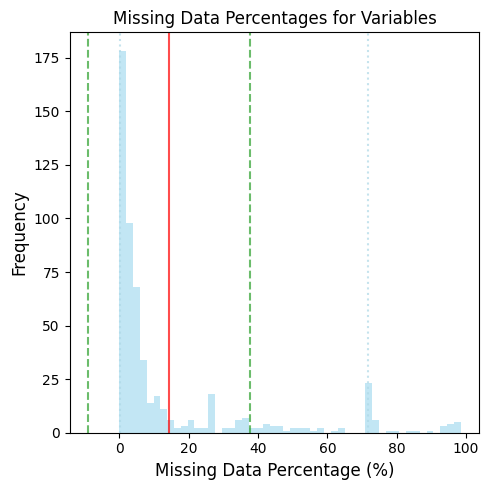

In [11]:
def plot_hist(x, bins, title, xlim=None, ylim=None, color ="skyblue",
              fig_size=(20,20), xlab="", ylab='', fontsize=10):
    """Plots a histogram with a red mean line (+/- 1SD in green dashes)
    and a 95 and 5 percentile dotted lines in blue."""
    plt.figure(figsize=fig_size)
    if xlim != None:
        plt.xlim(xlim)
    if ylim != None:
        plt.ylim(ylim)
    if (x.isnull().all() == False):
        plt.hist(x, bins = bins, color = color, alpha=0.5)
        plt.title(title, fontsize=fontsize)
        plt.xlabel(xlab, fontsize=fontsize)
        plt.ylabel(ylab, fontsize=fontsize)
        if (x.dtype == "float64") or (x.dtype == "int"):
                plt.axvline(x=np.mean(x) - np.std(x), ls="--", color='#2ca02c', alpha=0.7)
                plt.axvline(x=np.mean(x) + np.std(x), ls="--", color='#2ca02c', alpha=0.7)
                plt.axvline(x=np.mean(x), ls="-", color='red', alpha=0.7)
                plt.axvline(x=np.percentile(x, 5), ls="dotted", color='lightblue', alpha=0.7)
                plt.axvline(x=np.percentile(x, 95), ls="dotted", color='lightblue', alpha=0.7)
                plt.tight_layout()
                plt.show()
        else:
            print("not int or float")
    else:
            print("nas")

    return

plot_hist(fig_size=(5, 5),
          bins=50,
          fontsize=12,
          x=missing_summary["Missing_Perc"],
          title="Missing Data Percentages for Variables",
          xlab="Missing Data Percentage (%)",
          ylab="Frequency")


Choose cut off percentage as a way to drop variables. At what percentage is the missing data too high?

In [12]:
# choose cut-off
cut_off = 2

In [13]:
# drop variables with > missing data than cut-off value
drop_vars = missing_summary["Variable"][missing_summary["Missing_Perc"]>=cut_off]
df.drop(drop_vars, axis=1, inplace=True)

print("Dropped {} variables due to missing data. {} variables remaining".format(len(drop_vars), df.shape[1]))


Dropped 369 variables due to missing data. 180 variables remaining


Certain questions are repeats or recoded versions of the DV. These need to be removed from out IV pool so we are not predicting like with like.

In [14]:
remove_too_similar = ['Q275', 'Q275R', 'Q275A']

dropped_vars = 0
for var in remove_too_similar:
    if var in list(df.columns):
        df.drop(var, axis=1, inplace=True)
        dropped_vars = dropped_vars + 1

print("Dropped {} variables due to similarity with DV. {} variables remaining".format(dropped_vars, df.shape[1]))


Dropped 2 variables due to similarity with DV. 178 variables remaining


Check other features correlations with the DV in case of accidental information leakage.

In [15]:
# create a df of correlations of IVs to DV
corr_dv = pd.DataFrame(df.corrwith(other = df["DV_Ed_Binary"], method='pearson', numeric_only=True))
# rename column
corr_dv.columns = ["Pearson_r"]
# calculate absolute correlation
corr_dv['Absolute_corr'] = abs(corr_dv["Pearson_r"])
# sort data frame on absolute correlation (highest first)
corr_dv.sort_values(inplace=True, by='Absolute_corr', axis=0, ascending=False)
# round to 4 decimal places
corr_dv['Absolute_corr'] = round(corr_dv['Absolute_corr'], 4)
print(corr_dv[0:20])

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


              Pearson_r  Absolute_corr
DV_Ed_Binary   1.000000         1.0000
deathrate      0.164325         0.1643
Q100           0.143717         0.1437
Q206          -0.135377         0.1354
resemaval      0.134479         0.1345
choice         0.122263         0.1223
landWB         0.120780         0.1208
Q279          -0.118341         0.1183
Q41            0.102178         0.1022
I_WOMJOB       0.098165         0.0982
Q33            0.098165         0.0982
Q6             0.098109         0.0981
I_RELIGIMP     0.097953         0.0980
Q200          -0.097953         0.0980
Q185           0.096547         0.0965
I_DIVORLIB     0.096547         0.0965
equality       0.094132         0.0941
Q57           -0.091211         0.0912
Q7             0.090100         0.0901
Q54            0.089208         0.0892


Remove features which are meta-data features only

In [16]:
meta_data_only = ["version", "doi", "E1_LITERACY", "A_WAVE", "A_STUDY", "B_COUNTRY", "B_COUNTRY_ALPHA", "C_COW_NUM",
                  "C_COW_ALPHA", "A_YEAR", "D_INTERVIEW", "Partyname", "Partyabb", "cparty", "cpartyabb",
                  "J_INTDATE", "FW_END", "FW_START", "K_TIME_START", "K_TIME_END", "K_DURATION", "Q_MODE", "N_REGION_ISO",
                  "N_REGION_WVS", "N_TOWN", "G_TOWNSIZE", "I_PSU", "O1_LONGITUDE", "O2_LATITUDE", "S_INTLANGUAGE",
                  "LNGE_ISO", "W_WEIGHT", "S018", "pwght", "S025"]

In [17]:
dropped_vars=0
for var in meta_data_only:
    if var in list(df.columns):
        df.drop(var, axis=1, inplace=True)
        dropped_vars = dropped_vars+1

# define X
X = df.drop('DV_Ed_Binary', axis=1)

print("Dropped {} meta variables. {} independent variables remaining".format(dropped_vars, X.shape[1]))

Dropped 20 meta variables. 157 independent variables remaining


Check for extreme multicollinearity in X

In [19]:
# create correlation matrix
corr_iv = X.corr(method='pearson', min_periods=100).abs()

# drop repetitious pairs (diagonals and below in matrix):
corr_iv = (corr_iv.where(np.triu(np.ones(corr_iv.shape), k=1).astype(np.bool_))
                  .stack()
                  .sort_values(ascending=False))

# save as a df
corr_iv = pd.DataFrame(corr_iv)
# rename col
corr_iv.columns = ["Absolute_corr"]
print(corr_iv[0:25])

                        Absolute_corr
Q17        I_NONOBED         1.000000
Q33        I_WOMJOB          1.000000
Q8         I_INDEP           1.000000
Q11        I_IMAGIN          1.000000
Q171       I_RELIGPRAC       1.000000
Q185       I_DIVORLIB        1.000000
Q27        I_DEVOUT          0.999988
Q6         I_RELIGIMP        0.999979
Q30        I_WOMEDU          0.999949
GDPpercap1 GDPpercap2        0.999834
popWB1990  popWB2000         0.999650
popWB2000  popWB2019         0.998299
Q261       Q262              0.997759
popWB1990  popWB2019         0.996525
Q262       x003R             0.977363
Q261       x003R             0.975403
Q262       X003R2            0.909539
Q261       X003R2            0.907829
X003R2     x003R             0.899869
I_NORM2    relativism        0.866147
I_DIVORLIB choice            0.854526
Q185       choice            0.854526
I_NORM3    relativism        0.836688
Q6         disbelief         0.831311
I_RELIGIMP disbelief         0.831221


Plot distributions of correlations in a histogram to visualise how much of an issue multicollinearity is in our data

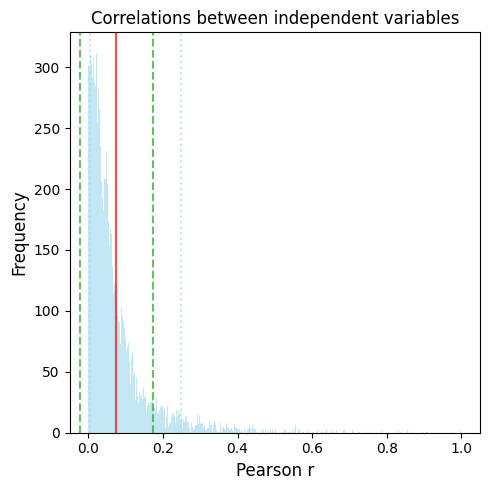

In [20]:
plot_hist(fig_size=(5, 5),
          bins=500,
          fontsize=12,
          x=corr_iv["Absolute_corr"],
          title="Correlations between independent variables",
          xlab="Pearson r",
          ylab="Frequency")

Remove correlated variables above a certain threshold

In [21]:
# set threshold
colinear_threshold = 0.95

In [22]:
# create df of correlations above threshold
colinear_df = corr_iv[corr_iv["Absolute_corr"] > colinear_threshold]
colinear_df.reset_index(inplace=True)
colinear_df.columns = ["Var_1", "Var_2", "Absolute_corr"]
print(colinear_df)

         Var_1        Var_2  Absolute_corr
0          Q17    I_NONOBED       1.000000
1          Q33     I_WOMJOB       1.000000
2           Q8      I_INDEP       1.000000
3          Q11     I_IMAGIN       1.000000
4         Q171  I_RELIGPRAC       1.000000
5         Q185   I_DIVORLIB       1.000000
6          Q27     I_DEVOUT       0.999988
7           Q6   I_RELIGIMP       0.999979
8          Q30     I_WOMEDU       0.999949
9   GDPpercap1   GDPpercap2       0.999834
10   popWB1990    popWB2000       0.999650
11   popWB2000    popWB2019       0.998299
12        Q261         Q262       0.997759
13   popWB1990    popWB2019       0.996525
14        Q262        x003R       0.977363
15        Q261        x003R       0.975403


In practice we would go through the different variables and work out which ones we would like to keep based on the data quality and the research question. For now, we will just arbitrarily remove half.

In [23]:
# for now, arbitrarily keep only first feature
drops = colinear_df["Var_2"]
X.drop(drops, inplace=True, axis=1)

print("Dropped {} variables due to replication. {} independent variables remaining".format(len(drops), X.shape[1]))


Dropped 16 variables due to replication. 143 independent variables remaining


# 4. Further pruning of the sample

- Drop individuals who have a lot of missing data
- Create a **balanced** sub-sample

Remove individuals with no DV information

In [24]:
# reconstruct new X and y df
y_df = pd.DataFrame(y, columns=['DV_Ed_Binary'])
X_and_y = pd.concat([X, y_df], axis=1)
# remove all individuals who we don't have y infomation for
X_and_y.dropna(axis=0, how='any', subset=["DV_Ed_Binary"], inplace=True)
# redefine X and y
X = X_and_y.drop("DV_Ed_Binary", axis=1)
y = X_and_y["DV_Ed_Binary"]

Look at missing data at the inidvidal (row) level

In [25]:
# create df consisting of counts of NAs for each individual
missing_indiv_level_df = pd.DataFrame(X.isnull().sum(axis=1))
# calculate percentage
missing_indiv_level_df["Percentage"] = round((missing_indiv_level_df[0] / X.shape[1]) * 100, 4)
# sort by percentage
missing_indiv_level_df.sort_values(by="Percentage", ascending=False, inplace=True)
print(missing_indiv_level_df[0:25])

              0  Percentage
Unnamed: 0                 
68816       108     75.5245
62252       100     69.9301
74441        88     61.5385
26385        80     55.9441
25933        80     55.9441
25972        79     55.2448
55891        79     55.2448
62367        79     55.2448
26825        78     54.5455
56940        75     52.4476
62237        75     52.4476
62364        74     51.7483
26382        73     51.0490
50656        72     50.3497
26606        71     49.6503
62247        70     48.9510
50857        69     48.2517
62249        68     47.5524
19383        68     47.5524
50553        67     46.8531
26978        67     46.8531
62366        67     46.8531
62255        67     46.8531
62371        67     46.8531
62372        67     46.8531


Plot missing data for indivdiuals in a histogram

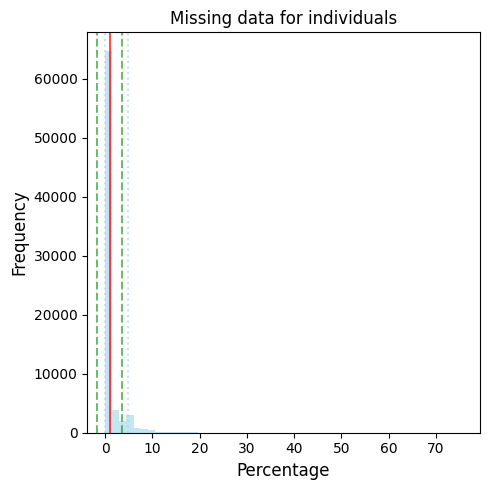

In [26]:
plot_hist(fig_size=(5,5),
          bins=50,
          fontsize=12,
          x=missing_indiv_level_df["Percentage"],
          title="Missing data for individuals",
          xlab="Percentage",
          ylab="Frequency")

Set missing threshold

In [27]:
# Set threshold (percentage)
missing_thresh_indiv_level = 20

In [28]:
# get minimum number of variables required (from percentage threshold)
min_count = missing_indiv_level_df[missing_indiv_level_df['Percentage'] < missing_thresh_indiv_level].iloc[0, 0]
# drop individuals who have missing data in more columns than min_count
X_and_y.dropna(axis=0, thresh=min_count +1, inplace=True)

For (mainly) computational reasons, we are now going to randomly select a sample of 0 labels to match the number of 1 labels, so that we have a smaller, **balanced** sample.

In [29]:
# define positive and negative labels
positive_labels = X_and_y[X_and_y["DV_Ed_Binary"]==1]
negative_labels = X_and_y[X_and_y["DV_Ed_Binary"]==0]
# get number of positive lables
n_positive = positive_labels.shape[0]
# create a random sample of negative labels with the same N as positive
negative_labels = negative_labels.sample(n=n_positive, replace=False, random_state=93, axis=0)
# define new X and y df
X_and_y = pd.concat([positive_labels, negative_labels], axis=0)
print(X_and_y.shape)

(10936, 144)


End data pre-processing stage!

In [30]:
end_data_preprocess = dt.datetime.now()
data_preprocess_time = end_data_preprocess - start
print("Data pre-processing done. Time taken: {}".format(str(data_preprocess_time)))

Data pre-processing done. Time taken: 0:01:03.407622
